# PGM - DM3 - Gibbs sampling and mean field VB for the probitmodel
Lucas Elbert

### 1.) Preprocess the data
It is important to normalize the predictors to give all predictors a priori the same chance of influence.
As the prior distributes all $\beta_i$ according to $N(0,\tau)$ we generally favour smaller $\beta_i$s over larger but we do not favor any predictor over another. Without rescaling predictors with numerically larger (absolute) values would have a much higher influence on the prediction. Therefore it is important rescale them to bring them all into the same range.
Furthermore the mean centering gives the advantage that however we choose $\beta$, in expectation our prediction will only be influenced by the bias ($\beta_i$ corresponding to the constant column).
Both aspects are covered by our mean-0-std-1 preprocessing.

In [18]:
import numpy as np
# Read
data = np.loadtxt('german.data-numeric')
# Add constant column as last predictor (class stays last column)
data_ = np.zeros((data.shape[0],data.shape[1]+1))
data_[:,:-2] = data[:,:-1]
data_[:,-2] = 1
data_[:,-1] = data[:,-1]
data = data_

# normalize predictors
for i in range(data.shape[1]-2):
    std = np.std(data[:,i])
    m = np.mean(data[:,i])
    data[:,i] -= m
    data[:,i] /= std
    
# Rename classes to {1, -1} (currently it is {1, 2})
for i in range(data.shape[0]):
    if data[i,-1] == 2:
        data[i,-1] = -1

tau = 100
X = data_[:,:-1]
y = data_[:,-1]

### 2.)  Why the noise is $N(0,1)$
Adding a parameter $\sigma$ and assuming $\epsilon_i \sim N(0,\sigma^2)$ does not extend our model. In fact we have
$$
y_i \sim sign(\beta^\top x_i + N(0,1)) = sign(\frac{\beta^\top x_i}{\sigma} + N(0,\sigma^2))
$$
Therefore the new parameter gives only a re- and over-parameterization of the model. Because all $\beta,\sigma$ pairs with the same ratio create the same model, the concrete values (apart from the ratio) would be determined by the prior only.

### 3.) Gibbs sampling

We now implement a Gibbs sampler of the posterior of $\beta$. As it is difficult to directly sample from $p(\beta|y)$ we introduce the hidden variables $z_i$ and will sample from $p(\beta,z|y)$
$$z_i = x_i\beta + \epsilon_i $$
In class we have seen the following **Theorem 1**:
$$
\begin{equation*}
 \text{If } x\sim N(\mu,\Sigma), \mu \sim N(m,S)\\ \text{then  }p(\mu|x) \propto p(x|\mu)p(\mu) = N(x;\mu,\Sigma)N(\mu;m,S) = N(m_p,S_p) \\ \text{  with } S_p = (S^{-1}+\Sigma^{-1})^{-1}, m_p = 
S_p(S^{-1}m + \Sigma^-1x)
\end{equation*}
$$

This can be applied here and we get
$$
\begin{align}
p(\beta|z,y) = p(\beta|z) &\propto p(z|\beta)p(\beta)\newline
& \sim N(z;X\beta,I_n)N(\beta;0,\tau I_p)\newline
& = N((X^\top X)^{-1}X^\top z; \beta, (X^\top X)^{-1}) N(\beta;0,\tau I_p)\newline
& = N(m_p,S_p)
\end{align}
$$
$$
\begin{align*}
S_p &= (\frac{1}{\tau}I_p + X^\top X)^{-1}\\
m_p &= S_p X^\top z
\end{align*}
$$

and

$$
p(z|\beta,y) \propto \prod_{i=1}^n N(z_i;\beta^\top x_i,1)\mathbb{1}_{(z_iy_i > 0)}
$$
We can then iteratively sample $\beta$ and $z$ from those two distributions

In [15]:
import numpy.random as random
from scipy.stats import truncnorm

def probit_gibbs(X,y,tau,num_burn_in,num_samples):

    def get_beta(z,S_p,X,S_p_X_t):
        m_p = np.matmul(S_p_X_t,z)
        return random.multivariate_normal(m_p,S_p)

    def get_z(beta,y,X):
        # Draw z from truncated normal
        z = np.zeros(len(y))
        m = np.matmul(X,beta)
        inf = 1000.0
        lower_limits = (y < 0)*-inf
        upper_limits = (y > 0)*inf
        lower_limits -= m
        upper_limits -= m
        z = m+truncnorm.rvs(lower_limits, upper_limits)
        return z

    # Variables.
    n,p = X.shape
    S_p = np.linalg.inv(np.identity(p)/tau + np.matmul(X.transpose(),X))
    S_p_X_t = np.matmul(S_p,X.transpose())
    # Initialization
    z = np.sign(y)
    beta = np.sqrt(tau)*random.randn(p)

    # Burn in
    print('burning in')
    for _ in range(num_burn_in):
        beta = get_beta(z,S_p,X,S_p_X_t)
        z = get_z(beta,y,X)

    # Sampling
    print('sampling')
    samples = np.empty((num_samples,p))
    for t in range(num_samples):
        beta = get_beta(z,S_p,X,S_p_X_t)
        z = get_z(beta,y,X)
        samples[t] = beta
    print('finished')
    return np.array(samples)

In [19]:
samples = probit_gibbs(X,y,tau=100,num_burn_in=5000,num_samples=10000)

burning in
sampling
finished


#### Visualize the marginal distribution of all $\beta_i$s
I visualize the marginal distributions by histograms of the Gibbs samples

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


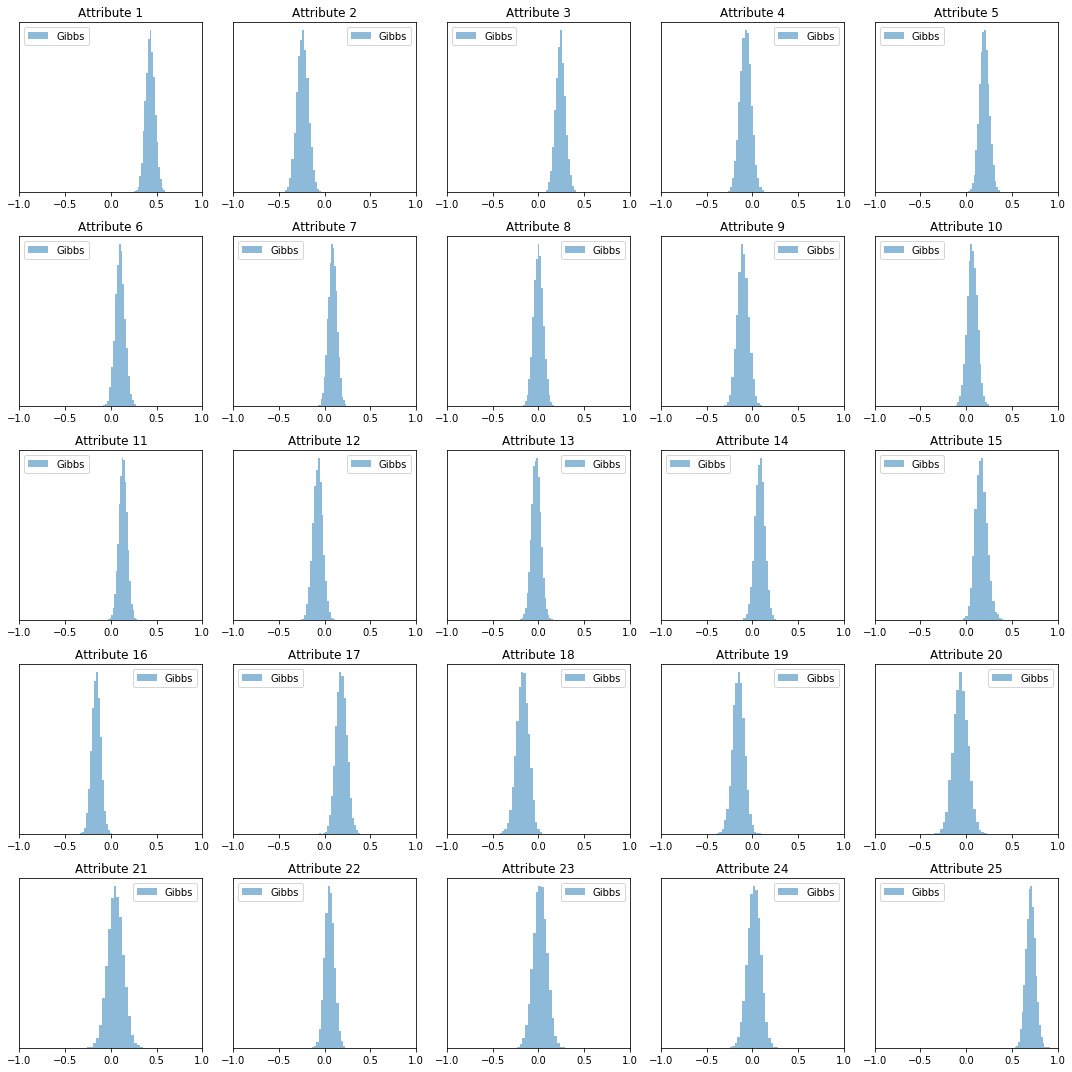

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.hist(samples[:,i], density=True, bins=20, histtype='stepfilled', alpha=0.5, label='Gibbs')
    ax.set_xlim(-1,1)
    ax.legend()
    #ax.axvline(x=np.mean(samples[:,i]),c='r')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_title('Attribute '+str(i+1))
    #ax.set_ylabel('Frequency')
fig.tight_layout()
fig.show()

### 4.) Mean field variational Bayes

In [5]:
def mean_field(X,y,tau,num_steps=500):
    n,p = X.shape
    # Initialize q_2 to the prior, then update q_1, q_2 iteratively
    q_1_mean = None
    q_1_cov = np.identity(n)
    q_2_mean = np.zeros(p)
    q_2_cov = tau * np.identity(p)
    S_p = np.linalg.inv(np.identity(p)/tau + np.matmul(X.transpose(),X))
    
    for t in range(num_steps):
        # update q_1
        usual_means = np.matmul(X,q_2_mean)
        inf = 1000.0
        lower_limits = (y < 0) * -inf
        lower_limits -= usual_means
        upper_limits = (y > 0) * inf
        upper_limits -= usual_means
        truncated_means = truncnorm.stats(lower_limits, upper_limits,moments='m')
        truncated_means += usual_means
        q_1_mean = truncated_means
        #q_1_cov = np.identity(n) # does not change fixed
        
        # update q_2
        q_2_mean = np.matmul(np.matmul(S_p,X.transpose()),q_1_mean)
        q_2_cov = S_p

    return q_1_mean, q_1_cov, q_2_mean, q_2_cov

In [6]:
_,_,q_2_mean, q_2_cov = mean_field(X,y,tau,num_steps=50)
beta_means = q_2_mean
beta_vars = q_2_cov.diagonal()

I plot the estimated marginal density functions on top of the gibbs histograms to compare the two.

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


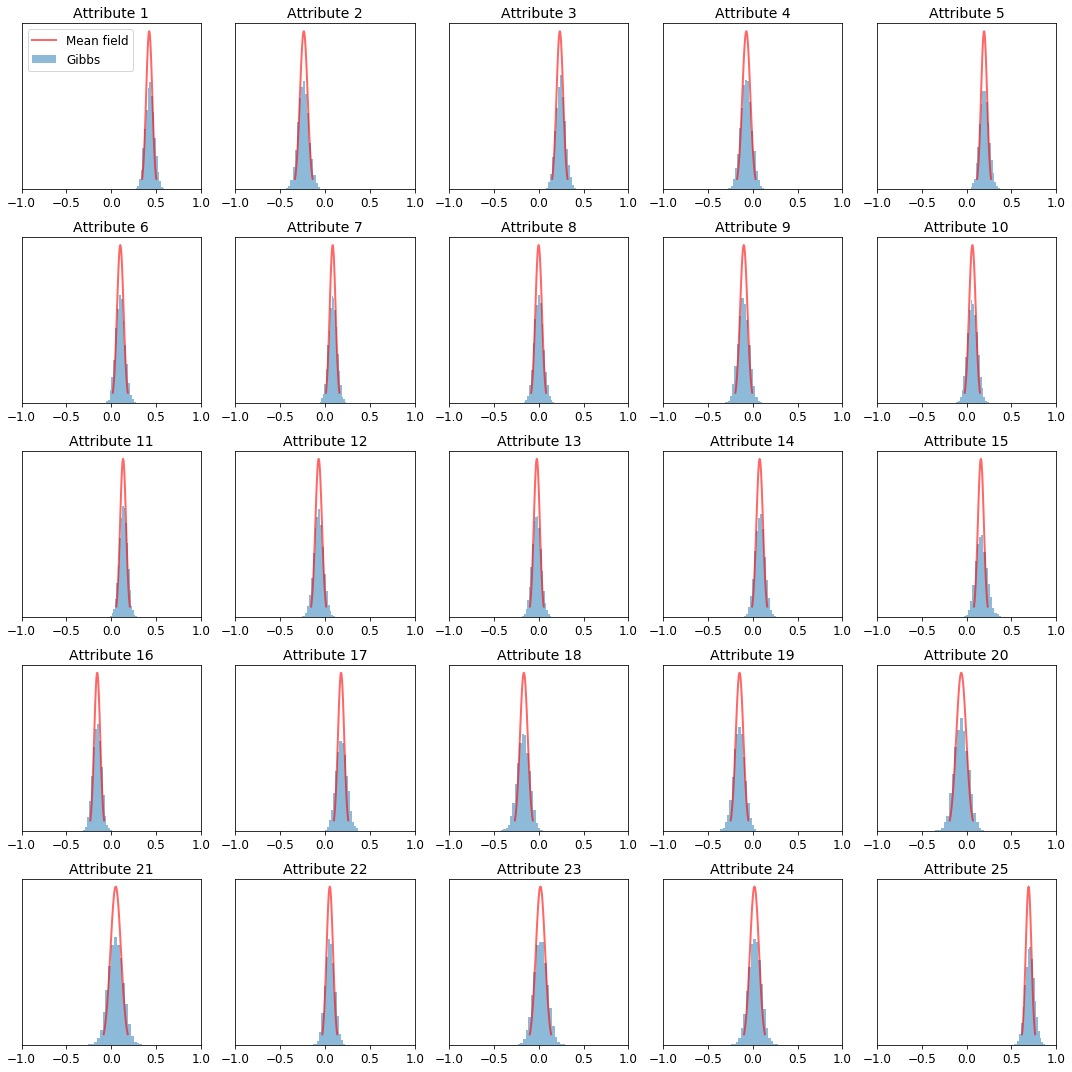

In [21]:
import scipy
fig = plt.figure(figsize=(15,15))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    dist = scipy.stats.norm()
    ax.hist(samples[:,i], density=True, bins=20, histtype='stepfilled', alpha=0.5, label='Gibbs')
    ax.set_xlim(-1,1)
    dist = scipy.stats.norm(loc = beta_means[i],scale = np.sqrt(beta_vars[i]))
    x = np.linspace(dist.ppf(0.01),dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x),'r-', lw=2, alpha=0.6, label='Mean field')
    ax.set_xlim(-1,1)
    if i == 0:
        ax.legend(fontsize=12)
    ax.set_yticklabels([])
    ax.tick_params(axis='x',labelsize=12)
    ax.set_yticks([])
    ax.set_title('Attribute '+str(i+1),fontsize=14)
    #ax.set_ylabel('Frequency')
fig.tight_layout()
fig.show()
#fig.savefig('comparison.png',dpi=100)

## 6.) complete separation

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


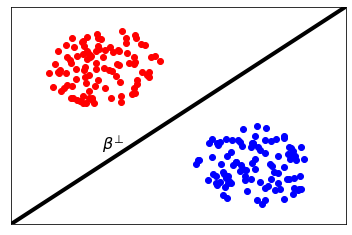

In [8]:
# Artificial data
def samples_in_circle(center_x,center_y,radius,n_samples):
    rs = radius*np.sqrt(np.random.rand(n_samples))
    thetas = np.random.rand(n_samples) * 2 * np.math.pi
    xs = center_x + rs * np.cos(thetas)
    ys = center_y + rs * np.sin(thetas) 
    return np.dstack([xs,ys])[0]

data = np.empty((200,4))
# coordinates (predictors)
data[:100,:2] = samples_in_circle(0,5,2,100)
data[100:,:2] = samples_in_circle(5,0,2,100)
# constant
data[:,2] = 1
# class
data[:100,3] = -1
data[100:,3] = 1

# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data[:100,0],data[:100,1], c='r')
ax.scatter(data[100:,0],data[100:,1], c='b')
ax.plot([-3,9],[-3,9],c='black',linewidth=4)
ax.text(0,0.8,r'$\beta^\bot$',fontsize=16)
ax.set_xlim(-3,8)
ax.set_ylim(-3,8)
ax.set_xticks([])
ax.set_yticks([])
fig.show()
#fig.savefig('complete_separation.jpg')

In [9]:
# Run Gibbs sampler

# normalize predictors
for i in range(data.shape[1]-2):
    std = np.std(data[:,i])
    m = np.mean(data[:,i])
    data[:,i] -= m
    data[:,i] /= std
    
#beta = np.array([1,-1,0])

tau = 100
X = data[:,:-1]
y = data[:,-1]

In [10]:
samples = probit_gibbs(X,y,tau=100,num_burn_in=10000,num_samples=100000)

burning in
sampling
finished


/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


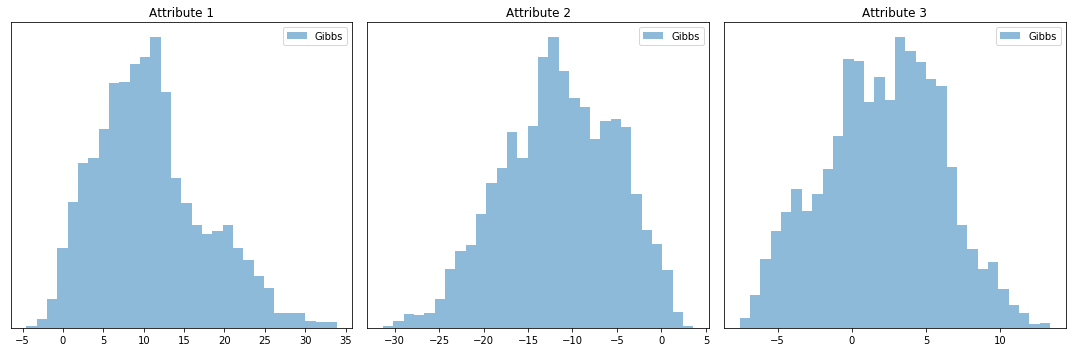

In [11]:
fig = plt.figure(figsize=(15,5))

for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.hist(samples[:,i], density=True, bins=30, histtype='stepfilled', alpha=0.5, label='Gibbs')
    #ax.plot(range(len(samples)),samples[:,i])
    #ax.set_xlim(-1,1)
    ax.legend()
    #ax.axvline(x=np.mean(samples[:,i]),c='r')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_title('Attribute '+str(i+1))
    #ax.set_ylabel('Frequency')
fig.tight_layout()
fig.show()
#fig.savefig('Gibbs_separation.jpg')